In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Hide TensorFlow Warning due to using GPU
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
tf.random.set_seed(42)
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

In [2]:
def plot_class_distribution(dataset_dir_path):
    # Directory path containing the image dataset
    dataset_dir = dataset_dir_path
    
    # Get the list of subdirectories (classes)
    classes = os.listdir(dataset_dir)
    
    # Initialize a dictionary to store the class names and image counts
    class_counts = {}
    
    # Iterate over the subdirectories
    for class_name in classes:
        # Get the path to the current class directory
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            # Get the count of images in the class directory
            image_count = len(os.listdir(class_dir))
            class_counts[class_name] = image_count
    
    # Extract the class names and image counts for plotting
    class_names = list(class_counts.keys())
    image_counts = list(class_counts.values())
    
    # Create a bar plot
    plt.bar(class_names, image_counts)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution")
    
    # Rotate the x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Display the plot
    plt.show()

## Load Data

In [3]:
data_dir = "../dataset/HouseHoldGarbage"
data_dir = pathlib.Path(data_dir) #pathlib.Path respect different semantics appropriate for different operating systems

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

15515


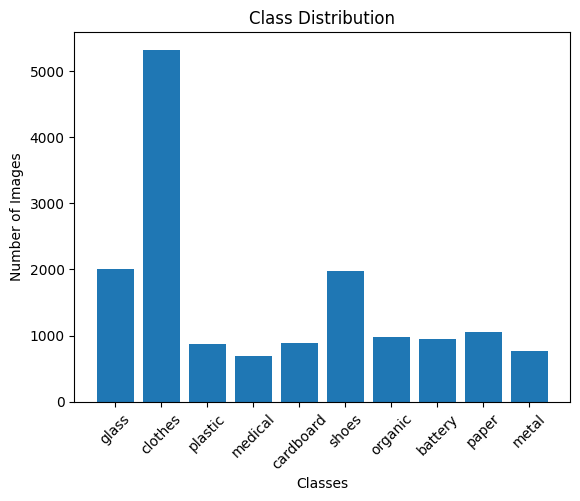

In [5]:
plot_class_distribution(data_dir)

In [6]:
batch_size = 32
img_height = 150
img_width = 150

In [7]:
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds_size = tf.data.experimental.cardinality(ds).numpy()
print(ds_size)

Found 15515 files belonging to 10 classes.
485


In [8]:
class_names = ds.class_names
print(class_names)

['battery', 'cardboard', 'clothes', 'glass', 'medical', 'metal', 'organic', 'paper', 'plastic', 'shoes']


In [9]:
# Keras Apllications Pretrained Model Preprocessing
def preprocess(images, labels):
    return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels
    # mobilenet_v2.preprocess_input will scale input pixels between -1 and 1.

# Apply preprocess
ds = ds.map(preprocess)

In [10]:
# Split dataset
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=15515):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=123)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1)

In [11]:
# Configure dataset for performance  
# https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Build

In [12]:
num_classes = len(class_names)

# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a custom classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
388/388 [==============================] - 64s 154ms/step - loss: 0.4518 - accuracy: 0.8551 - val_loss: 0.2028 - val_accuracy: 0.9349
Epoch 2/10
388/388 [==============================] - 58s 149ms/step - loss: 0.2392 - accuracy: 0.9204 - val_loss: 0.1283 - val_accuracy: 0.9544
Epoch 3/10
388/388 [==============================] - 59s 151ms/step - loss: 0.1803 - accuracy: 0.9379 - val_loss: 0.1432 - val_accuracy: 0.9453
Epoch 4/10
388/388 [==============================] - 57s 148ms/step - loss: 0.1478 - accuracy: 0.9476 - val_loss: 0.0911 - val_accuracy: 0.9701
Epoch 5/10
388/388 [==============================] - 57s 148ms/step - loss: 0.1257 - accuracy: 0.9564 - val_loss: 0.0920 - val_accuracy: 0.9688
Epoch 6/10
388/388 [==============================] - 58s 148ms/step - loss: 0.1083 - accuracy: 0.9620 - val_loss: 0.0868 - val_accuracy: 0.9701
Epoch 7/10
388/388 [==============================] - 58s 149ms/step - loss: 0.0967 - accuracy: 0.9658 - val_loss: 0.0981 - val_ac

## Eval


In [20]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 0s 141ms/step


In [21]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       109
         1.0       0.99      0.95      0.97        83
         2.0       1.00      0.98      0.99       511
         3.0       0.95      0.96      0.96       216
         4.0       1.00      0.98      0.99        60
         5.0       0.95      0.93      0.94        86
         6.0       0.97      0.98      0.97        95
         7.0       0.94      0.98      0.96       127
         8.0       0.90      0.90      0.90        83
         9.0       0.97      0.99      0.98       198

    accuracy                           0.97      1568
   macro avg       0.97      0.97      0.97      1568
weighted avg       0.97      0.97      0.97      1568



In [22]:
confusion_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
print(confusion_matrix)

[[107   1   0   0   0   1   0   0   0   0]
 [  0  79   0   0   0   0   0   4   0   0]
 [  0   0 503   0   0   1   0   1   1   5]
 [  0   0   0 208   0   0   2   0   5   1]
 [  0   0   0   0  59   0   0   0   1   0]
 [  0   0   0   5   0  80   0   0   1   0]
 [  0   0   0   0   0   1  93   1   0   0]
 [  0   0   0   1   0   0   0 125   0   1]
 [  1   0   0   4   0   1   0   2  75   0]
 [  0   0   0   1   0   0   1   0   0 196]]


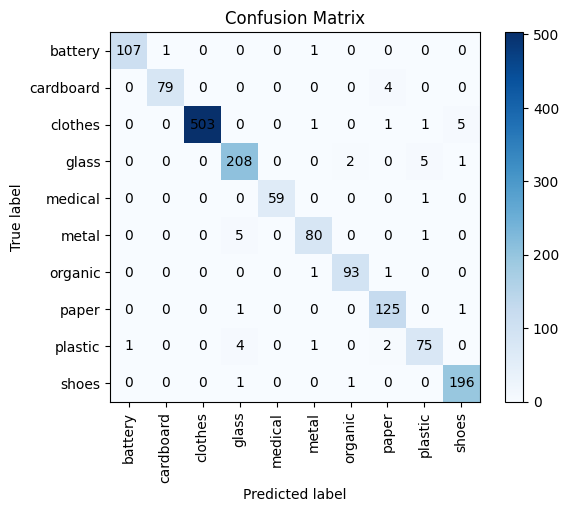

In [23]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=90)  # Rotate x-axis labels vertically
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

# Add the value annotations to the plot
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

# Display the colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

## Saving models

In [26]:
model.save('../saved_models/Trash Classifier/model.h5')